In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle

print(tf.__version__) 


Found GPU at: 
2.2.0


In [11]:
from IPython.display import clear_output, display
import os.path
from os import path
import shutil
import PIL
from pathlib import Path
from matplotlib import pyplot as plt

In [12]:
BASE_DIR= '/mestrado/datasets'
IMG_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_parts', 'images')
LABELS_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_parts', 'labels')

In [13]:
def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def write_label( path, text):
  f= open( path, "w")
  f.write( text)
  f.close()

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

def show_gimage( img, name= 'noname'):
  plt.imshow( img, cmap= 'gray')
  plt.title( name)
  plt.show()

def _load_image( path):
  # return cv2.imread( path, cv2.IMREAD_GRAYSCALE)
  return cv2.imread( path)
  
def write_image( path, img):
  cv2.imwrite( path, img)

def resize( img, scale_percent= 60, verbose=False):
  #scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  if verbose:
    print( "scale", scale_percent)
    print( "dim", dim)
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

In [14]:
def _load_all():
    all_images= glob( os.path.join( IMG_ORG_DIR, "*.jpg"))
    all_images.sort()
    all_images_content= [_load_image( f) for f in all_images]    
    all_images_content= np.asarray( all_images_content)

    all_labels=glob( os.path.join( LABELS_ORG_DIR, "*.pgn"))
    all_labels.sort()

    all_labels_content= [read_label( f) for f in all_labels]
    return all_images, all_images_content, all_labels, all_labels_content

def cut( img, lines, cols):
    cuts= []
    h= (int)(img.shape[ 0]/lines)
    w= (int)(img.shape[ 1]/cols)

    for i in range(0,lines):
      for j in range(0,cols):
        cuts.append( img[ (i*h):(i+1)*h, (j*w):(j+1)*w])
    return np.array( cuts)

def rebuild( cuts):
#     print( 'len(cuts)', len( cuts))
    col1= np.concatenate((
            cuts[ 0], cuts[ 2], cuts[ 4], cuts[ 6], cuts[ 8], 
            cuts[10], cuts[12], cuts[14], cuts[16], cuts[18],
            cuts[20], cuts[22], cuts[24], cuts[26], cuts[28],
            cuts[30], cuts[32], cuts[34], cuts[36], cuts[38],
            cuts[40], cuts[42], cuts[44], cuts[46], cuts[48]
          ), axis= 0)
    col2= np.concatenate((
            cuts[ 1], cuts[ 3], cuts[ 5], cuts[ 7], cuts[ 9], 
            cuts[11], cuts[13], cuts[15], cuts[17], cuts[19],
            cuts[21], cuts[23], cuts[25], cuts[27], cuts[29],
            cuts[31], cuts[33], cuts[35], cuts[37], cuts[39],
            cuts[41], cuts[43], cuts[45], cuts[47], cuts[49]
          ), axis= 0)
    d= 50
    col3= np.concatenate((
            cuts[d+ 0], cuts[d+ 2], cuts[d+ 4], cuts[d+ 6], cuts[d+ 8], 
            cuts[d+10], cuts[d+12], cuts[d+14], cuts[d+16], cuts[d+18],
            cuts[d+20], cuts[d+22], cuts[d+24], cuts[d+26], cuts[d+28],
            cuts[d+30], cuts[d+32], cuts[d+34], cuts[d+36], cuts[d+38],
            cuts[d+40], cuts[d+42], cuts[d+44], cuts[d+46], cuts[d+48]
          ), axis= 0)
    col4= np.concatenate((
            cuts[d+ 1], cuts[d+ 3], cuts[d+ 5], cuts[d+ 7], cuts[d+ 9], 
            cuts[d+11], cuts[d+13], cuts[d+15], cuts[d+17], cuts[d+19],
            cuts[d+21], cuts[d+23], cuts[d+25], cuts[d+27], cuts[d+29],
            cuts[d+31], cuts[d+33], cuts[d+35], cuts[d+37], cuts[d+39],
            cuts[d+41], cuts[d+43], cuts[d+45], cuts[d+47], cuts[d+49]
          ), axis= 0)
    
    return np.concatenate((col1, col2, col3, col4), axis= 1)

def _shuffle( img, label, k):
    cuts= cut( img, 8, 2)

    newcuts, newlabel= shuffle( cuts, label, random_state= k)
    newimg= rebuild( newcuts)
    return newimg, newlabel


In [15]:
_blank= _load_image( 'C:\mestrado\datasets\carnaval_8lines_shuffle_parts_blank\_blank.jpg')

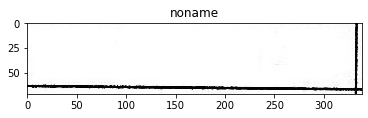

In [16]:
show_image( _blank)

In [23]:
IMG_TARGET_DIR= path.join( BASE_DIR, 'carnaval_fullpage_shuffle_from_parts_7k', 'images')
LABELS_TARGET_DIR= path.join( BASE_DIR, 'carnaval_fullpage_shuffle_from_parts_7k', 'labels')

all_images, all_image_content, all_labels_files, label_content= _load_all()

new_cuts= all_image_content
new_labels= label_content

size= len( new_cuts)

def get_random_n( n):
    s= set()
    cuts= []
    labels= []
    while n> 0:
        i= np.random.randint(0, size)
        if not new_labels[i] in s:
            cuts.append( new_cuts[i])
            labels.append( new_labels[i])
            n= n-1
            s.add( new_labels[i])
    return cuts, labels

def generate(N):
    count= 0;
    
    for i in range( 0, N):
        
        # quantidade aleatoria
        n= np.random.randint( 1, 100)
        cuts, labels= get_random_n( n)
        
        for j in range( n, 100):
            cuts.append( _blank)
        img= rebuild( cuts)
        tag= "shuffled_"+str(i+1).zfill(5) 
        write_image( os.path.join( IMG_TARGET_DIR, tag+ ".jpg"), resize( img, 50))
        write_label( os.path.join( LABELS_TARGET_DIR, tag+ ".pgn"), " ".join( labels))
        if i>0 and i%100== 0:
            print( i)
            
generate(7000)
print( "DONE")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
DONE


In [3]:
s= set()

In [6]:
s.add( 'ec')

In [7]:
'ec' in s

True

In [9]:
x= []
x.append( 'x')
print( x)

['x']
